In [2]:
import numpy as np
from sympy import Symbol, Function, Number

import modulus
from modulus.hydra import to_absolute_path, to_yaml, instantiate_arch
from modulus.hydra.config import ModulusConfig
from modulus.continuous.solvers.solver import Solver
from modulus.continuous.domain.domain import Domain
from modulus.continuous.constraints.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
    PointwiseConstraint,
)
from modulus.continuous.validator.validator import PointwiseValidator
from modulus.geometry.csg.csg_2d import Rectangle
from modulus.key import Key
from modulus.PDES.wave_equation import WaveEquation
from modulus.pdes import PDES
from modulus.tensorboard_utils.plotter import ValidatorPlotter


In [3]:
import modulus
from modulus.hydra import to_yaml
from modulus.hydra.utils import compose
from modulus.hydra.config import ModulusConfig

cfg = compose(config_path="conf", config_name="config")
cfg.network_dir = 'outputs'    # Set the network directory for checkpoints
print(to_yaml(cfg))

training:
  max_steps: 40000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: 1000
  rec_inference_freq: 1000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  amp: false
  amp_dtype: float16
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs
initialization_network_dir: ''
save_filetypes: vtk
summary_histograms: true
jit: true
device: ''
debug: false
run_mode: train
arch:
  fully_connected:
    _target_: modulus.architecture.fully_connected.FullyConnectedArch
    layer_size: 256
    nr_layers: 6
    skip_connections: false
    adaptive_activations: false
    weight_norm: true
loss:
  _target_: modulus.aggregator.Sum
  weights: null
optimizer:
  _params_:
    compute_gradients: adam_compute_gradients
    apply_gradients: adam_apply_gradients
  _target_: torch.optim.Adam
  lr: 0.0003
  beta

In [4]:
# Read in npz files generated using finite difference simulator Devito
def read_wf_data(time, dLen):
    wf_filename = to_absolute_path(f"Training_data/wf_{int(time):04d}ms.npz")
    print(wf_filename)
    wave = np.load(wf_filename)["arr_0"].astype(np.float32)
    mesh_y, mesh_x = np.meshgrid(
        np.linspace(0, dLen, wave.shape[0]),
        np.linspace(0, dLen, wave.shape[1]),
        indexing="ij",
    )
    invar = {}
    invar["x"] = np.expand_dims(mesh_y.astype(np.float32).flatten(), axis=-1)
    invar["y"] = np.expand_dims(mesh_x.astype(np.float32).flatten(), axis=-1)
    invar["t"] = np.full_like(invar["x"], time * 0.001)
    outvar = {}
    outvar["u"] = np.expand_dims(wave.flatten(), axis=-1)
    return invar, outvar


In [5]:
# define open boundary conditions
class OpenBoundary(PDES):
    """
    Open boundary condition for wave problems
    Ref: http://hplgit.github.io/wavebc/doc/pub/._wavebc_cyborg002.html

    Parameters
    ==========
    u : str
        The dependent variable.
    c : float, Sympy Symbol/Expr, str
        Wave speed coefficient. If `c` is a str then it is
        converted to Sympy Function of form 'c(x,y,z,t)'.
        If 'c' is a Sympy Symbol or Expression then this
        is substituted into the equation.
    dim : int
        Dimension of the wave equation (1, 2, or 3). Default is 2.
    time : bool
        If time-dependent equations or not. Default is True.
    """

    name = "OpenBoundary"

    def __init__(self, u="u", c="c", dim=3, time=True):
        # set params
        self.u = u
        self.dim = dim
        self.time = time

        # coordinates
        x, y, z = Symbol("x"), Symbol("y"), Symbol("z")

        # normal
        normal_x, normal_y, normal_z = (
            Symbol("normal_x"),
            Symbol("normal_y"),
            Symbol("normal_z"),
        )

        # time
        t = Symbol("t")

        # make input variables
        input_variables = {"x": x, "y": y, "z": z, "t": t}
        if self.dim == 1:
            input_variables.pop("y")
            input_variables.pop("z")
        elif self.dim == 2:
            input_variables.pop("z")
        if not self.time:
            input_variables.pop("t")

        # Scalar function
        assert type(u) == str, "u needs to be string"
        u = Function(u)(*input_variables)

        # wave speed coefficient
        if type(c) is str:
            c = Function(c)(*input_variables)
        elif type(c) in [float, int]:
            c = Number(c)

        # set equations
        self.equations = {}
        self.equations["open_boundary"] = (
            u.diff(t)
            + normal_x * c * u.diff(x)
            + normal_y * c * u.diff(y)
            + normal_z * c * u.diff(z)
        )


In [6]:
class WavePlotter(ValidatorPlotter):
    "Define custom validator plotting class"

    def __call__(self, invar, true_outvar, pred_outvar):

        # only plot x,y dimensions
        invar = {k: v for k, v in invar.items() if k in ["x", "y"]}
        fs = super().__call__(invar, true_outvar, pred_outvar)
        return fs


In [7]:

# override defaults
cfg.arch.fully_connected.layer_size = 128

# define PDEs
we = WaveEquation(u="u", c="c", dim=2, time=True)
ob = OpenBoundary(u="u", c="c", dim=2, time=True)

# define networks and nodes
wave_net = instantiate_arch(
    input_keys=[Key("x"), Key("y"), Key("t")],
    output_keys=[Key("u")],
    cfg=cfg.arch.fully_connected,
)
speed_net = instantiate_arch(
    input_keys=[Key("x"), Key("y")],
    output_keys=[Key("c")],
    cfg=cfg.arch.fully_connected,
)
nodes = (
    we.make_nodes(detach_names=["c"])
    + ob.make_nodes(detach_names=["c"])
    + [
        wave_net.make_node(name="wave_network", jit=cfg.jit),
        speed_net.make_node(name="speed_network", jit=cfg.jit),
    ]
)


In [30]:
    # define geometry
    dLen = 2  # km
    rec = Rectangle((0, 0), (dLen, dLen))

    # define sympy domain variables
    x, y, t = Symbol("x"), Symbol("y"), Symbol("t")

    # define time range
    time_length = 1
    time_range = {t: (0.15, time_length)}

    # define target velocity model
    # 2.0 km/s at the bottom and 1.0 km/s at the top using tanh function
    mesh_x, mesh_y = np.meshgrid(
        np.linspace(0, 2, 512), np.linspace(0, 2, 512), indexing="ij"
    )
    wave_speed_invar = {}
    wave_speed_invar["x"] = np.expand_dims(mesh_x.flatten(), axis=-1)
    wave_speed_invar["y"] = np.expand_dims(mesh_y.flatten(), axis=-1)
    wave_speed_outvar = {}
    wave_speed_outvar["c"] = np.tanh(80 * (wave_speed_invar["y"] - 1.0)) / 2 + 1.5 # plot tan(80x) on https://www.desmos.com/calculator


In [9]:
import matplotlib.pyplot as plt

In [19]:
np.shape(wave_speed_outvar["c"])

(262144, 1)

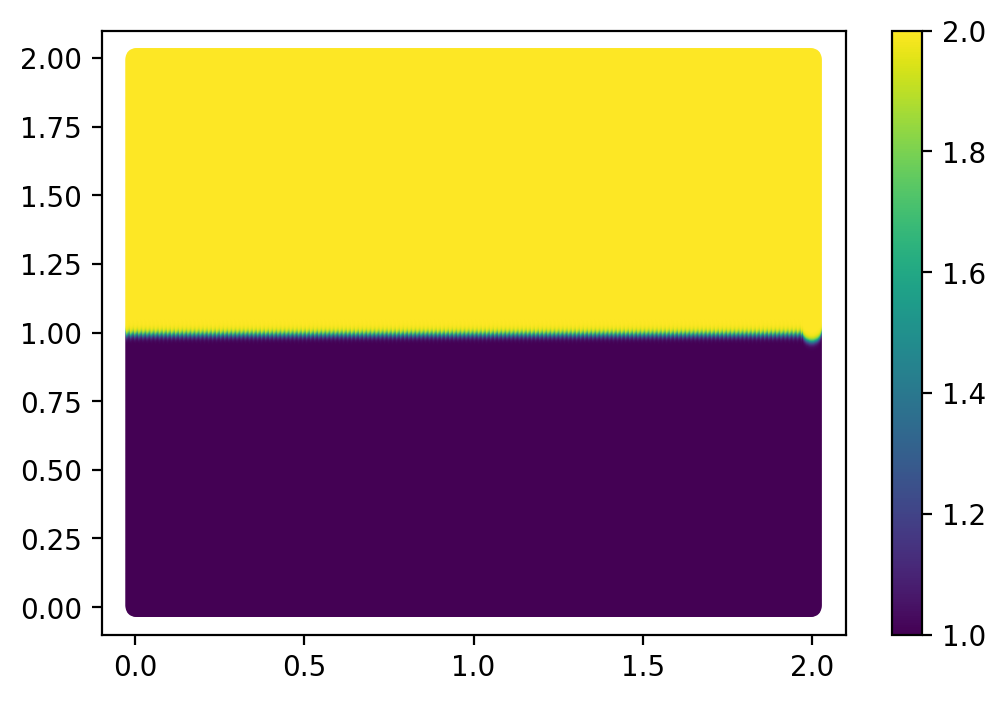

In [31]:
%matplotlib inline
plt.figure(2, dpi=200)
plt.scatter(wave_speed_invar["x"], wave_speed_invar["y"], c=wave_speed_outvar["c"])
plt.colorbar()
plt.show()

In [32]:
    # make domain
    domain = Domain()

    # add velocity constraint
    velocity = PointwiseConstraint.from_numpy(
        nodes=nodes, invar=wave_speed_invar, outvar=wave_speed_outvar, batch_size=1024
    )
    domain.add_constraint(velocity, "Velocity")

    # add initial timesteps constraints
    batch_size = 1024
    for i, ms in enumerate(np.linspace(150, 300, 4)):
        timestep_invar, timestep_outvar = read_wf_data(ms, dLen)
        lambda_weighting = {}
        lambda_weighting["u"] = np.full_like(timestep_invar["x"], 10.0 / batch_size)
        timestep = PointwiseConstraint.from_numpy(
            nodes,
            timestep_invar,
            timestep_outvar,
            batch_size,
            lambda_weighting=lambda_weighting,
        )
        domain.add_constraint(timestep, f"BC{i:04d}")

    # add interior constraint
    interior = PointwiseInteriorConstraint(
        nodes=nodes,
        geometry=rec,
        outvar={"wave_equation": 0},
        batch_size=4096,
        bounds={x: (0, dLen), y: (0, dLen)},
        lambda_weighting={"wave_equation": 0.0001},
        param_ranges=time_range,
    )
    domain.add_constraint(interior, "Interior")

    # add open boundary constraint
    edges = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=rec,
        outvar={"open_boundary": 0},
        batch_size=1024,
        lambda_weighting={"open_boundary": 0.01 * time_length},
        param_ranges=time_range,
    )
    domain.add_constraint(edges, "Edges")

    # add validators
    for i, ms in enumerate(np.linspace(350, 950, 13)):
        val_invar, val_true_outvar = read_wf_data(ms, dLen)
        validator = PointwiseValidator(
            val_invar, val_true_outvar, nodes, batch_size=1024, plotter=WavePlotter()
        )
        domain.add_validator(validator, f"VAL_{i:04d}")
    validator = PointwiseValidator(
        wave_speed_invar,
        wave_speed_outvar,
        nodes,
        batch_size=1024,
        plotter=WavePlotter(),
    )
    domain.add_validator(validator, "Velocity")

/scratch/s.1915438/nht_b/5. After first review/more example/sample_seismic_wave/Training_data/wf_0150ms.npz
/scratch/s.1915438/nht_b/5. After first review/more example/sample_seismic_wave/Training_data/wf_0200ms.npz
/scratch/s.1915438/nht_b/5. After first review/more example/sample_seismic_wave/Training_data/wf_0250ms.npz
/scratch/s.1915438/nht_b/5. After first review/more example/sample_seismic_wave/Training_data/wf_0300ms.npz
/scratch/s.1915438/nht_b/5. After first review/more example/sample_seismic_wave/Training_data/wf_0350ms.npz
/scratch/s.1915438/nht_b/5. After first review/more example/sample_seismic_wave/Training_data/wf_0400ms.npz
/scratch/s.1915438/nht_b/5. After first review/more example/sample_seismic_wave/Training_data/wf_0450ms.npz
/scratch/s.1915438/nht_b/5. After first review/more example/sample_seismic_wave/Training_data/wf_0500ms.npz
/scratch/s.1915438/nht_b/5. After first review/more example/sample_seismic_wave/Training_data/wf_0550ms.npz
/scratch/s.1915438/nht_b/5. 

In [33]:
# to make the logging work in the jupyter cells
# execute this cell only once
import logging
logging.getLogger().addHandler(logging.StreamHandler())

In [35]:
import os
from modulus.continuous.solvers.solver import Solver

# optional
# set appropriate GPU in case of multi-GPU machine
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

# make solver
slv = Solver(cfg, domain)

# start solver
slv.solve()

Installed PyTorch version 1.12.0+cu113 is not TorchScript supported in Modulus. Version 1.11.0a0+17540c5 is officially supported.
attempting to restore from: /scratch/s.1915438/nht_b/5. After first review/more example/sample_seismic_wave/outputs
optimizer checkpoint not found
model speed_network.pth not found
model wave_network.pth not found
[step:          0] saved contraint results to outputs
[step:          0] record contraint batch time:  1.160e+00s
locator: <matplotlib.ticker.AutoLocator object at 0x7f9f0f0a4160>
locator: <matplotlib.ticker.AutoLocator object at 0x7f9f0f05d9a0>
locator: <matplotlib.ticker.AutoLocator object at 0x7f9f0f1dcbe0>
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(FontEntry(fname='/scratch/s.1915438/modulus_pysdf/modulus_pysdf/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'

KeyboardInterrupt: 